# Esquema del modelo definitivo

## I. Librerias y funciones

In [116]:
#Librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from lazypredict.Supervised import LazyRegressor
import pickle

In [59]:
# Función para convertir los datos en secuencias de tiempo
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    # Ajuste para asegurarse de que no excedamos el rango del conjunto de datos
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


## II. Procesado del DF

In [45]:
print(os.getcwd())

c:\Users\minip\OneDrive - Universidad de Málaga\Documentos\4Geek\Proyecto final\AMH-proyecto-final\src\Proceso de modelos


In [46]:
print(os.path.exists('../data/DF_modelos/df_industrial_total.csv'))

False


In [60]:
#Covid transofromar en niveles de restricciones
df = pd.read_csv(r'C:/Users/minip/OneDrive - Universidad de Málaga/Documentos/4Geek/Proyecto final/AMH-proyecto-final/data/DF_modelos/df_industrial_total.csv')
df = df.drop(columns=['Sector_Economic','año','poblacion','velmedia','prec','Empleo','PIB','lectivos'])  

In [61]:
#Analizar los valores de df
df

,consumo,fecha,findesemana,festivos,COVID,tmed
0,995989,2019-01-01,0,1,0,8.59
1,1702091,2019-01-02,0,0,0,6.62
2,1826076,2019-01-03,0,0,0,5.60
3,1806926,2019-01-04,0,0,0,5.00
4,1341548,2019-01-05,1,0,0,6.17
...,...,...,...,...,...,...
2003,1403736,2024-06-26,0,0,0,22.62
2004,1365435,2024-06-27,0,0,0,23.78
2005,1358576,2024-06-28,0,0,0,24.45
2006,994740,2024-06-29,1,0,0,20.94


In [62]:
#Eliminar consumos anomalos
index_primera_menor_1000 = df[df['consumo'] < 1000].index.min()

# Eliminar todas las filas desde ese índice en adelante
if index_primera_menor_1000 is not None:
    df = df.loc[:index_primera_menor_1000-1]

df

,consumo,fecha,findesemana,festivos,COVID,tmed
0,995989,2019-01-01,0,1,0,8.59
1,1702091,2019-01-02,0,0,0,6.62
2,1826076,2019-01-03,0,0,0,5.60
3,1806926,2019-01-04,0,0,0,5.00
4,1341548,2019-01-05,1,0,0,6.17
...,...,...,...,...,...,...
1943,799363,2024-04-27,1,0,0,14.11
1944,749970,2024-04-28,1,0,0,12.46
1945,1066271,2024-04-29,0,0,0,11.62
1946,1076872,2024-04-30,0,0,0,13.54


In [63]:
#Consumo previo 3 dias
df['t-1'] = df['consumo'].shift(1)
#df['t-2'] = df['consumo'].shift(2)
#df['t-3'] = df['consumo'].shift(3)

In [64]:
#Eliminar filas con valores nulos
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df

,consumo,fecha,findesemana,festivos,COVID,tmed,t-1
0,1702091,2019-01-02,0,0,0,6.62,995989.00
1,1826076,2019-01-03,0,0,0,5.60,1702091.00
2,1806926,2019-01-04,0,0,0,5.00,1826076.00
3,1341548,2019-01-05,1,0,0,6.17,1806926.00
4,1201714,2019-01-06,1,0,0,9.13,1341548.00
...,...,...,...,...,...,...,...
1942,799363,2024-04-27,1,0,0,14.11,1076123.00
1943,749970,2024-04-28,1,0,0,12.46,799363.00
1944,1066271,2024-04-29,0,0,0,11.62,749970.00
1945,1076872,2024-04-30,0,0,0,13.54,1066271.00


In [65]:
#Formatear 
df['COVID'].replace(2,3,inplace=True)
df['COVID'].replace(1,2,inplace=True)
df['COVID'].replace(3,1,inplace=True)

In [66]:
df.dtypes

consumo          int64
fecha           object
findesemana      int64
festivos         int64
COVID            int64
tmed           float64
t-1            float64
dtype: object

In [67]:
df.nunique()

consumo        1915
fecha          1947
findesemana       2
festivos          2
COVID             3
tmed           1847
t-1            1915
dtype: int64

In [68]:
df.shape

(1947, 7)

In [69]:
# Asegúrate de que la columna de fecha está en formato datetime
# Convertir la columna de fecha a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y')  # Ajusta el formato según tus datos

# Convertir la columna de fecha a timestamp
df['fecha'] = df['fecha'].astype(np.int64) // 10**9  # Convertir a dias

In [70]:
df

,consumo,fecha,findesemana,festivos,COVID,tmed,t-1
0,1702091,1546387200,0,0,0,6.62,995989.00
1,1826076,1546473600,0,0,0,5.60,1702091.00
2,1806926,1546560000,0,0,0,5.00,1826076.00
3,1341548,1546646400,1,0,0,6.17,1806926.00
4,1201714,1546732800,1,0,0,9.13,1341548.00
...,...,...,...,...,...,...,...
1942,799363,1714176000,1,0,0,14.11,1076123.00
1943,749970,1714262400,1,0,0,12.46,799363.00
1944,1066271,1714348800,0,0,0,11.62,749970.00
1945,1076872,1714435200,0,0,0,13.54,1066271.00


## III. Analisis de variables potenciales

In [14]:
# Definir características (X) y objetivo (y)
X = df.drop(columns=['consumo'])  
y = df['consumo']  

test_size_percentage = 0.09
split_index = int(len(X) * (1 - test_size_percentage))

# Dividir en conjunto de entrenamiento (primera parte) y prueba (última parte)
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

In [15]:
#Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Modelo para seleccion de caracteristicas importantes
# Definir el modelo XGBoost
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Entrenar el modelo con los datos de entrenamiento
model_xgb.fit(X_train_scaled, y_train)

# Realizar predicciones con los datos de prueba
y_pred = model_xgb.predict(X_test_scaled)

# Calcular el error cuadrático medio (RMSE) como métrica de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Obtener la importancia de las características
importancia = model_xgb.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importance = pd.DataFrame({'Variable': X.columns, 'Importancia': importancia*100})
feature_importance = feature_importance.sort_values(by='Importancia', ascending=False)
# Mostrar las variables ordenadas por importancia
print(feature_importance)

C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 104769.0501597512
      Variable  Importancia
1  findesemana    37.844616
5          t-1    36.166225
2     festivos    10.263535
3        COVID     8.327732
0        fecha     5.259157
4         tmed     2.138731


In [17]:
# convertir de array a pandas para el VIF
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_X_train_selected = df_X_train_scaled[['findesemana', 't-1', 'festivos', 'COVID', 'tmed', 'fecha']]
df_X_train_selected

,findesemana,t-1,festivos,COVID,tmed,fecha
0,-0.632456,-1.337818,-0.196748,-0.629797,-1.391208,-1.731073
1,-0.632456,0.193103,-0.196748,-0.629797,-1.545792,-1.729117
2,-0.632456,0.461918,-0.196748,-0.629797,-1.637348,-1.727161
3,1.581139,0.420398,-0.196748,-0.629797,-1.458879,-1.725205
4,1.581139,-0.588602,-0.196748,-0.629797,-1.007733,-1.723249
...,...,...,...,...,...,...
1766,-0.632456,-1.423132,-0.196748,-0.629797,-0.601038,1.723249
1767,1.581139,-1.355940,-0.196748,-0.629797,-0.363522,1.725205
1768,1.581139,-1.929540,-0.196748,-0.629797,-0.266659,1.727161
1769,-0.632456,-2.105375,-0.196748,-0.629797,-0.523414,1.729117


In [18]:
#Test VIF
vif = pd.Series([variance_inflation_factor(df_X_train_selected.corr().values, i) for i in range(df_X_train_selected.corr().shape[1])], index=df_X_train_selected.columns)
vif

findesemana    1.111830
t-1            2.913607
festivos       1.079916
COVID          1.797220
tmed           1.284506
fecha          3.385639
dtype: float64

## IV. Modelo LSTM

### IV.I. Preparar datos

In [71]:
#Ordenar los datos cronologicamnte
df = df.sort_values(by='fecha')

In [72]:
# Definir características (X) y objetivo (y)
X = df.drop(columns=['consumo','fecha'])  
y = df['consumo']

In [73]:
# Escalar los datos con MinMaxScaler (LSTM es sensible a la escala de los datos)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [74]:
# Dividir en conjunto de entrenamiento y prueba (manteniendo el orden temporal)
train_size = int(len(X) * 0.9)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [75]:
X_train

array([[0.        , 0.        , 0.        , 0.17305586, 0.17568884],
       [0.        , 0.        , 0.        , 0.13898399, 0.40067953],
       [0.        , 0.        , 0.        , 0.11880408, 0.44018582],
       ...,
       [0.        , 0.        , 0.        , 0.57753139, 0.21425069],
       [0.        , 0.        , 0.        , 0.65459524, 0.24578116],
       [0.        , 0.        , 0.        , 0.57799097, 0.24978739]])

In [76]:
X_test

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.09680107e-01,
        2.14303581e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.32908722e-01,
        1.75231912e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.13459971e-01,
        7.41989210e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.86743955e-01,
        4.71433975e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.88184119e-01,
        1.72706709e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.13774581e-01,
        1.67843661e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.92739434e-01,
        1.55161245e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.94910755e-01,
        1.73820666e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.94033368e-01,
        1.63713480e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.02953472e-01,
        7.36935617e-02],
       [0.00000000e+00, 0.0000

In [77]:
y_train

array([[0.40067953],
       [0.44018582],
       [0.43408391],
       ...,
       [0.24578116],
       [0.24978739],
       [0.21430358]])

In [78]:
y_test

array([[1.75231912e-01],
       [7.41989210e-02],
       [4.71433975e-02],
       [1.72706709e-01],
       [1.67843661e-01],
       [1.55161245e-01],
       [1.73820666e-01],
       [1.63713480e-01],
       [7.36935617e-02],
       [5.07312575e-02],
       [1.37685244e-01],
       [1.63753947e-01],
       [6.54099385e-02],
       [1.63150766e-01],
       [1.73025665e-01],
       [8.87268864e-02],
       [6.28853723e-02],
       [1.52793767e-01],
       [1.59824188e-01],
       [1.67409039e-01],
       [1.78614251e-01],
       [1.69431751e-01],
       [9.45493524e-02],
       [6.91816525e-02],
       [1.68802123e-01],
       [1.89194615e-01],
       [1.61673561e-01],
       [1.74056458e-01],
       [1.73216211e-01],
       [9.26920134e-02],
       [6.73768888e-02],
       [1.69064681e-01],
       [1.73016425e-01],
       [1.61419607e-01],
       [1.81639716e-01],
       [1.66914195e-01],
       [9.02878923e-02],
       [6.51830685e-02],
       [1.76353198e-01],
       [1.82659356e-01],


In [105]:
# Crear secuencias de tiempo para LSTM
time_steps = 2  # Esto significa que la predicción se basará en los últimos 2 dias
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
print(f"Forma de X_train_seq: {X_train_seq.shape}")  # Debe ser (samples, time_steps, features)

Forma de X_train_seq: (1750, 2, 5)


In [106]:
X_train_seq

array([[[0.        , 0.        , 0.        , 0.17305586, 0.1373185 ],
        [0.        , 0.        , 0.        , 0.13898399, 0.37278213]],

       [[0.        , 0.        , 0.        , 0.13898399, 0.37278213],
        [0.        , 0.        , 0.        , 0.11880408, 0.41412738]],

       [[0.        , 0.        , 0.        , 0.11880408, 0.41412738],
        [1.        , 0.        , 0.        , 0.15814028, 0.40774143]],

       ...,

       [[1.        , 0.        , 0.        , 0.58469672, 0.08669779],
        [0.        , 0.        , 0.        , 0.51435951, 0.05904615]],

       [[0.        , 0.        , 0.        , 0.51435951, 0.05904615],
        [0.        , 0.        , 0.        , 0.57753139, 0.17767534]],

       [[0.        , 0.        , 0.        , 0.57753139, 0.17767534],
        [0.        , 0.        , 0.        , 0.65459524, 0.2106735 ]]])

### IV.II. Definir modelo LSTM

In [107]:
# Definir el modelo LSTM
model = Sequential()

In [108]:
# Primera capa LSTM con 50 unidades y dropout para regularización
model.add(LSTM(16, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
# Segunda capa LSTM
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
# Capa de salida para la predicción continua de la demanda de electricidad
model.add(Dense(1))

In [109]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [110]:
# Mostrar el resumen del modelo
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 2, 16)          │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,713 (30.13 KB)

 Trainable params: 7,713 (30.13 KB)

 Non-trainable params: 0 (0.00 B)

### IV.III Entrenamiento del Modelo

In [111]:
# Entrenamiento conm 100 epocas
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0991 - val_loss: 0.0371
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 - val_loss: 0.0309
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 - val_loss: 0.0307
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - val_loss: 0.0275
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.0288
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - val_loss: 0.0202
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0202
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0166
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0160
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - val_loss: 0.0185
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0146
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

### IV.IV. Evaluacion del Modelo

In [112]:
# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Loss: {loss}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019
Loss: 0.0020298294257372618


In [113]:
#Comprobar la prediccion
# Predecir los valores de prueba
y_pred_scaled = model.predict(X_test_seq)
# Desescalar las predicciones y los valores reales para comparar
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_seq)
# Comparar las primeras predicciones con los valores reales
print(f"Predicciones: {y_pred[:5].flatten()}")
print(f"Valores reales: {y_test_true[:5].flatten()}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Predicciones: [ 726801.9  1005944.    942769.25  982135.    940327.1 ]
Valores reales: [592567. 986630. 971368. 931566. 990126.]


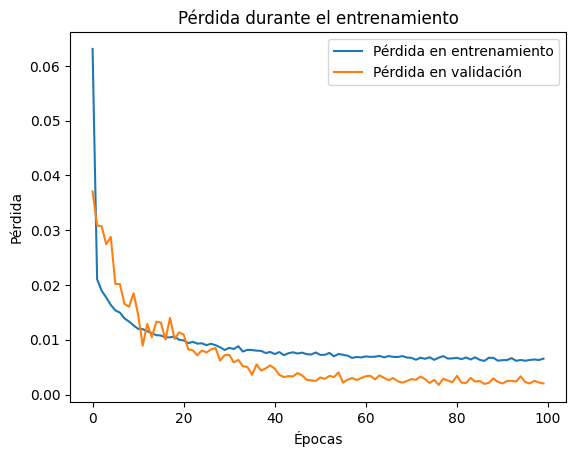

In [114]:
# Visualizar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## V. Guardar modelo no vaya a ser que se nos borre 

In [115]:
#Extraccion del modelo en la carpeta modelos
model.save('../models/modelo_industrial_Def.h5')

In [117]:
# Guardamos el objeto escalador x con pickle
with open('scaler_X_ind.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

In [118]:
# Guardamos el objeto escalador y con pickle
with open('scaler_y_ind.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)